# Nedostajuće vrednosti u podacima
Kada postoje nedostajuće vrednosti u podacima, nije moguće pronaći parametre modela. Zbog toga je potrebno obraditi nedostajuće vrednosti. Metode se dele u dve glavne grupe:
- za [uklanjanje podataka](#uklanjanje-podataka) i 
- [popunjavanje podataka](#popunjavanje-podataka).

Učitavamo neophodne pakete i skup podataka:

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
import statsmodels.api as sm

matplotlib.rcParams['figure.figsize'] = (8, 3)
sb.set(font_scale=1.)

In [2]:
df = pd.read_csv('data/missing_data_housing.csv', sep=',')
df.head()

,price,lotsize(m^2),bedrooms,bathrms,stories,driveway,recroom,fullbase,gashw,airco,garagepl,prefarea
0,74700,NaN,3,1,1.0,1,1,1,0,0,2,1
1,85000,652.4388,3,1,NaN,1,0,1,0,1,2,1
2,68500,NaN,3,1,2.0,1,0,1,0,0,0,0
3,82900,650.5800,3,1,1.0,1,0,1,0,0,2,1
4,86000,641.2860,3,2,NaN,1,1,1,0,0,0,1


In [3]:
def check_for_missing_values(df): 
    '''Find missing values and return non-zero missing value counts.'''
    missing_values = df.isna().sum()
    non_zero_missing = missing_values[missing_values != 0]
    non_zero_missing_percentage = (non_zero_missing / len(df)) * 100
    return pd.DataFrame({
        'N missing': non_zero_missing,
        '% missing': non_zero_missing_percentage
    })

check_for_missing_values(df)

,N missing,% missing
lotsize(m^2),168,60.0
stories,56,20.0


Vidimo da postoje nedostajuće vrednosti u dve kolone `lotsize(m^2)` i `stories`. Ako bismo probali da nađemo regresioni model koji koristi bar jednu od ovih kolona dobili bi grešku.

In [5]:
# ovaj kod rezultuje MissingDataError greškom
# x = df.drop(columns=['price'])
# y = df['price']

# x_with_const = sm.add_constant(x)
# all_vars_model = sm.OLS(y, x_with_const).fit() 

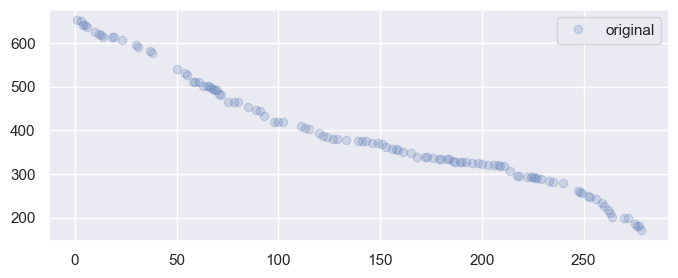

In [ ]:
def visualize_column(df, col_name,  df_fixed=None):
    '''plot values from a specified column.'''
    x = df.index
    plt.plot(x, df[col_name], 'bo', alpha=.2, label='original')
    if df_fixed is not None: plt.plot(x, df_fixed[col_name], 'r-', label='fixed')
    plt.legend()

visualize_column(df, col_name='lotsize(m^2)')

## Uklanjanje podataka
Prva grupa metoda su metode za uklanjanje podataka. Možemo ukloniti čitav red ili čitavu kolonu.

### Uklanjanje redova
U praksi najčešći metod za obradu nedostajućih vrednosti jer je najlakši za implementirati. Uklanjaju se svi redovi kojima nedostaje bar jedna vrednost. 
Problematično je ako ima puno redova koje treba ukloniti, jer tada gubimo puno podataka (smanjujemo uzorak), što može dovesti do lošeg modela.

Da izbacimo sve redove koji sadrže bar jednu nedostajuću vrednost koristimo metodu `dropna()`.

In [6]:
df_fixed = df.dropna()

num_deleted_rows = len(df) - len(df_fixed)
print(num_deleted_rows)

check_for_missing_values(df_fixed)

193


,N missing,% missing


### Uklanjanje kolona
Uklanjanjem kolone koja sadrži puno nedostajućih vrednosti možemo da pojednostavimo i poboljšamo performanse modela. 
Ako kolona ima puno nedostajućih vrednosti, verovatno je cela kolona neiformativna i bolje je izbaciti tu kolonu (nego npr. sve redove).
Ukoliko je kolona veoma informativna(kao što je npr. `lotsize(m^2)`), onda izbacivanje kolone nije preporučljivo jer dobijamo lošiji model, pa se takva kolona zadržava u podacima.

Da izbacimo kolonu koristimo metodu `drop(columns=[])`.

In [7]:
df_fixed = df.drop(columns=['stories'])

check_for_missing_values(df_fixed)

,N missing,% missing
lotsize(m^2),168,60.0


## Popunjavanje podataka
Brisanje podataka može dovesti do smanjivanja uzorka podataka i samim tim do lošijeg modela. Umesto da brišemo podatke, nedostajuće vrednosti možemo da popunimo (eng. *data imputation*).
Ne postoji univerzalno najbolji način za popunjavanje, jer zavisi od problema koji se rešava.
Iako ne znamo koja konkretna vrednost treba da stoji (umesto nedostajuće vrednosti), možemo da procenimo.

### Popunjavanje prosekom
Da nedostajuće vrednosti zamenimo prosekom vrednosti te kolone koristimo metodu `fillna()`.

*Napomena: ne mora nužno da se koristi srednja vrednost, nekada medijan ili mod daju bolje rezultate.*

,N missing,% missing


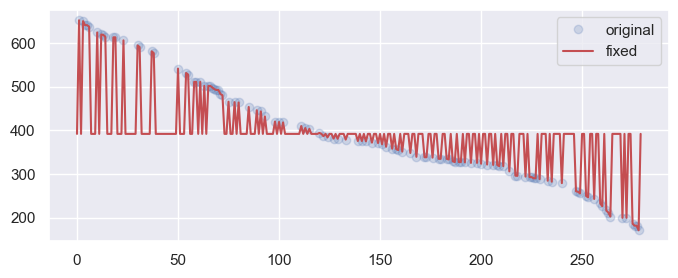

In [8]:
def fillna_mean(df, col_name):
    df_copy = df.copy()
    col_mean = df_copy[col_name].mean()
    df_copy[col_name] = df[col_name].fillna(col_mean)
    return df_copy

df_fixed = fillna_mean(df, 'lotsize(m^2)')
df_fixed = fillna_mean(df_fixed, 'stories')

visualize_column(df, 'lotsize(m^2)', df_fixed)

check_for_missing_values(df_fixed)

### Popunjavanje polinomom
Interpolacija je tehnika koja pronalazi "skrivenu" funkciju koja najbolje opsiuje podatke. Interpolacija funkcioniše tako što pronalazi polinom koji prolazi kroz tačke (podatke).

U narednim primerima pokazaćemo interpolaciju za površinu placa. Ekvivaletno bismo mogli primeniti interpolaciju i na kolonu `stories` koja ima nedostajuce vrednosti.
Primer: interpolirarmo (i ekstrapoliramo) vrednosti u koloni `lotsize(m^2)` polinomom 1, 3, i 10. stepena. Na sledećem grafiku se vidi da se polinom 10. stepena najbolje uklopio u podatke. 

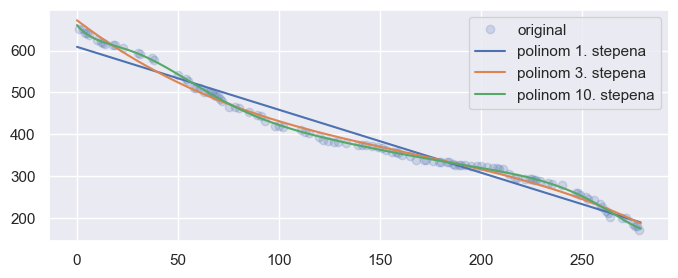

In [9]:
# x i y koje koristimo su vrednosti koje ne nedostaju
lotsize = df['lotsize(m^2)'].dropna().values
x = df['lotsize(m^2)'].dropna().index.values

# traži koeficijenta polinoma
p1 = np.polyfit(x, lotsize, deg=1)
p3 = np.polyfit(x, lotsize, deg=3)
p10 = np.polyfit(x, lotsize, deg=10)

# za svako x računamo y_pred
x = df.index
y1_pred = np.polyval(p1, x)
y3_pred = np.polyval(p3, x)
y10_pred = np.polyval(p10, x)

# vizualizacija
visualize_column(df, 'lotsize(m^2)')
plt.plot(x, y1_pred, label='polinom 1. stepena')
plt.plot(x, y3_pred, label='polinom 3. stepena')
plt.plot(x, y10_pred, label='polinom 10. stepena')
plt.legend();

### Popunjavanje splajnom
Umesto da tražimo jedan polinom koji će opisati sve vrednosti atributa, možemo da tražimo polinom nad delovima vrednosti; između svake dve tačke formiramo poseban interpolacioni polinom. Ovakva interpolacija zove se interpolacija splajnom. Rezultat interpolacije splajnom nije jedan polinom nego skup polinoma.
Koristimo funkciju `interpolate()` i definišemo parametar `method`. Ovaj parametar govori koja interpolaciona tehnika se koristi.

#### Linearni splajn
*Napomena: nije isto što i linearna regresija.* Pretpostavlja linearan odnos između dve susedne vrednosti $a$ i $c$ i aproksimira nepoznatu vrednost $b$ (nalazi se između dve poznate vrednosti: ...$a$, $b$, $c$...). Između svake dve tačke formiramo polinom prvog stepena. Primer: imamo 4 podatka (a,b,c,d) = (2, NaN, NaN, 5). Znamo $a$ i $d$, a pitamo se vrednosti za $b$ i $c$.
```python
a, d = 2, 5
a,b,c,d = interpolated = np.linspace(a,d, num=4) # 2, 3, 4, 5
```

Za linearni splajn koristimo ugrađenu metodu `interpolate(method='linear', limit_direction='both')`. Drugi parametar govori da se radi i ekstrapolacija pored interpolacije, kako bi dobili i početne i krajnje tačke. Obrati pažnju koliko se linearni splajn bolje uklopio u podatke za razliku od interpolacionog polinoma.

,N missing,% missing
stories,56,20.0


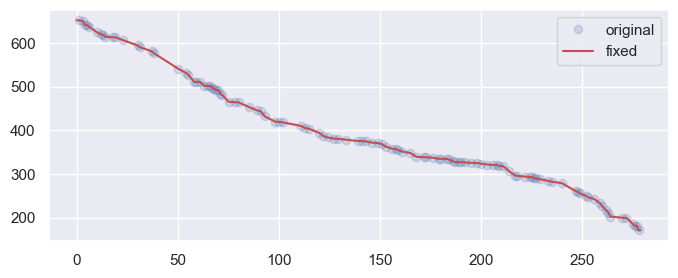

In [10]:
df_fixed = df.copy()
df_fixed['lotsize(m^2)'] = df['lotsize(m^2)'].interpolate(method='linear', limit_direction='both')
visualize_column(df, 'lotsize(m^2)', df_fixed)
check_for_missing_values(df_fixed)

#### Ostali splajnovi
Linerani splajn je veoma gruba interpolacija. Prelaz iz jedne u drugu tačku je retko linearan. Zato se često između dve tačke traži polinom većeg stepena.
Na taj način prelazi između tačaka nisu 'grubi' kao kod linearnog splajna.
U praksi se često koriste splajnovi 1, 2, i 3. stepena (retko je potreban veći stepen).

,N missing,% missing
stories,56,20.0


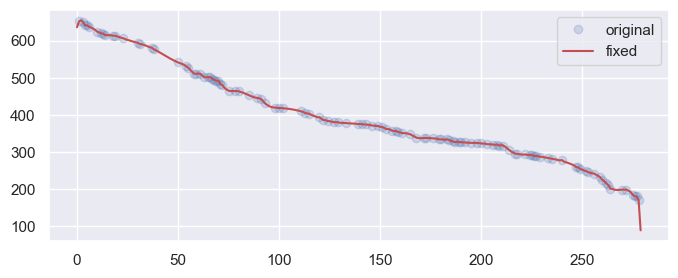

In [11]:
df_fixed = df.copy()
df_fixed['lotsize(m^2)'] = df['lotsize(m^2)'].interpolate(method='spline', order=3, limit_direction='both')
visualize_column(df, 'lotsize(m^2)', df_fixed)
check_for_missing_values(df_fixed)

*Napomena: Ekstrapolacija splajnom nekad nije dobra ideja. Pogledaj desni kraj splajna i uoči koliko se ne uklapa u podatke. To je zato što ekstrapoliramo poslednjih par vrednosti u podacima (fali poslednjih par vrednosti). U ovakvoj situaciji bilo bi bolje iskoristiti neku od prethodnih tehnika, umesto da ekstrapoliramo.*

### Trend u podacima
Podaci u koloni `lotsize(m^2)` su sortirani u opadajućem redosledu. Šta da kolona nije bila sortirana? Šta bi bilo da smo izmešali redove u podeli na trening i test skup i zatim primenili interpolaciju? Demonstriramo na primeru:

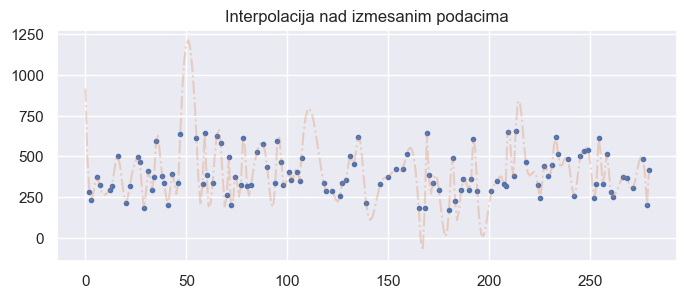

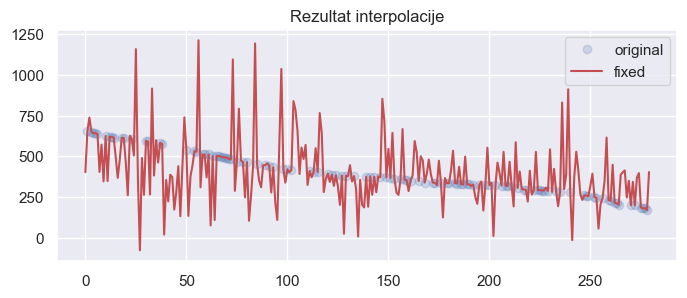

In [12]:
# nije neophodno razumeti sledeci kod
# izmesamo redosled podataka u DataFrame objektu
df_fixed2 = shuffle(df, random_state=42).reset_index(drop=False)
# plotujemo izmesane podatke
plt.plot(df_fixed2['lotsize(m^2)'], '.')
# interpoliramo nad izmesanim podacima
df_fixed2['lotsize(m^2)'] = df_fixed2['lotsize(m^2)'].interpolate(method='spline', order=3, limit_direction='both')
# plotujemo interpolirane vrednosti
plt.plot(df_fixed2['lotsize(m^2)'], '-.', alpha=.3)
plt.title('Interpolacija nad izmesanim podacima')
plt.show()

# sada ponistimo mesanje podataka (vracamo se na originalne podatke)
df_fixed2 = df_fixed2.sort_values(by='index').reset_index(drop=True).drop(columns='index')
# prikazujemo rezultat interpolacije
plt.title('Rezultat interpolacije')
visualize_column(df, 'lotsize(m^2)', df_fixed2)

Sa prvog grafika vidimo da je rezultat interpolacije (nad izmešanim podacima) pronašao odgovarajući splajn.
Sa drugog grafika vidimo da rezultat interpolacije ne prati trend u podacima za površinu placa. 
Možemo zaključiti da interpolacija nad izmešanim podacima ne daje dobre rezultate. Interpolaciju treba iskoristiti pre mešanja podataka.

*Savet: kada se primenjuje interpolacija nad nekom kolonom osigurati se da postoji trend u podacima. U koliko trend ne postoji, onda interpolacija uglavnom nije dobar izbor.*

# Zadaci
**TODO 1:** Napraviti regresione modele koji predviđaju cenu kuće koristeći `statsmodels` paket i sve atribute. Podeliti podatke na trening i validacioni skup u odnosu 70/30. Testirati svaki model koristeći prilagođeni $r^2$ meru. Zaključiti koji je model najbolji. Modeli se razlikuju po načinu obrade nedostajućih vrednosti:
1. Izbacuje sve redove kojima nedostaje vrednost.
1. Izbacuje atribut `stories`, a atribut `lotsize(m^2)` popunjava srednjom vrednošću.
1. Nedostajuće vrednosti popunjava kubnim splajnom.
1. Nedostajuće vrednosti atributa `stories` popunjava linearnim splajnom. Ostale nedostajuće vrednosti popunjava kvadratnim splajnom.
